Loading datasets...
Datasets loaded successfully

Testing Regular Autoencoder:

Regular Autoencoder Parameters:
Encoder parameters: 565,248
Decoder parameters: 565,248
Total parameters: 1,130,496

Testing Tied Weights Autoencoder:

Tied Weights Autoencoder Parameters:
Encoder parameters (only stored weights): 565,248
Decoder parameters: 0 (uses transposed encoder weights)
Total unique parameters: 565,248

Architecture Explanation:
1. Weight Tying in TiedAutoencoder:
   - Decoder weights are transpose of encoder weights
   - Reduces parameters by half
   - Follows PCA's reconstruction principle

2. Activation Functions:
   - Encoder: LeakyReLU with slope 0.2
   - Decoder: Inverse LeakyReLU with slope 1/0.2 = 5
   - Ensures proper reconstruction through inverse transformations

Training Tied Weights Autoencoder...
Using device: cpu
Epoch [1/40], Loss: 0.147881
Epoch [2/40], Loss: 0.085493
Epoch [3/40], Loss: 0.078652
Epoch [4/40], Loss: 0.075953
Epoch [5/40], Loss: 0.074119
Epoch [6/40],

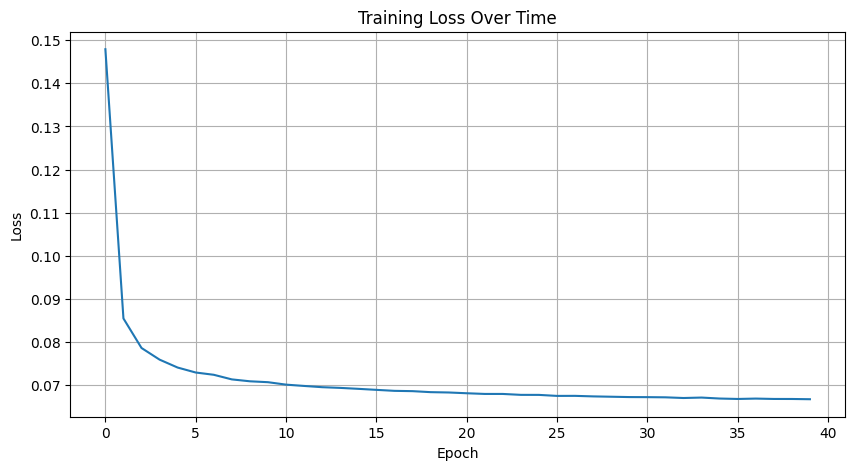

Generating visualizations...


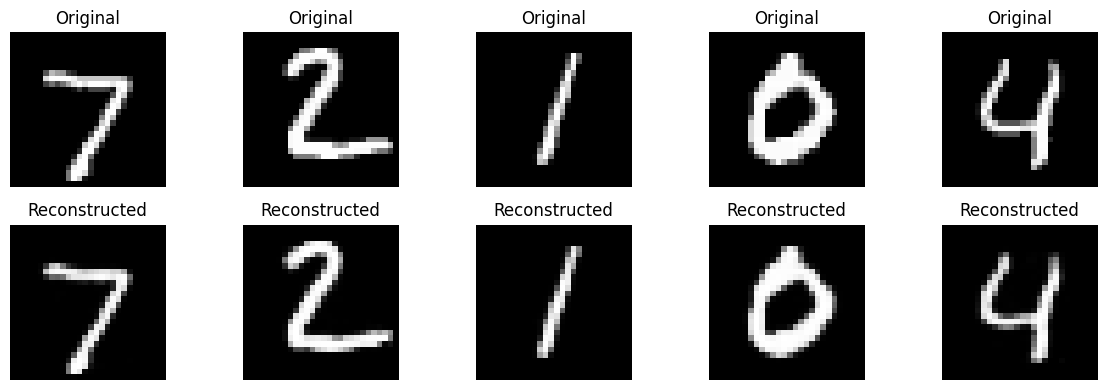

Training completed!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Custom Dataset class for MNIST
class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        # Read CSV file
        data = pd.read_csv(csv_file)

        # Separate labels and features
        self.labels = data.iloc[:, 0].values
        self.features = data.iloc[:, 1:].values

        # First normalize to [0,1]
        self.features = self.features / 255.0

        # Then center the data
        self.features = self.features - np.mean(self.features, axis=0)

        # Rescale to [0,1] after centering
        min_vals = np.min(self.features, axis=0)
        max_vals = np.max(self.features, axis=0)
        self.features = (self.features - min_vals) / (max_vals - min_vals + 1e-8)

        # Convert to tensors
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Regular Autoencoder with 3 layers
class Autoencoder(nn.Module):
    def __init__(self, input_size=784, latent_size=128):
        super(Autoencoder, self).__init__()

        # Define intermediate layer sizes
        h1_size = 512  # First hidden layer
        h2_size = 256  # Second hidden layer

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_size, h1_size, bias=False),
            nn.ReLU(),
            nn.Linear(h1_size, h2_size, bias=False),
            nn.ReLU(),
            nn.Linear(h2_size, latent_size, bias=False)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, h2_size, bias=False),
            nn.ReLU(),
            nn.Linear(h2_size, h1_size, bias=False),
            nn.ReLU(),
            nn.Linear(h1_size, input_size, bias=False),
            nn.Sigmoid()
        )

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def count_parameters(self):
        """Count the number of trainable parameters"""
        encoder_params = sum(p.numel() for p in self.encoder.parameters() if p.requires_grad)
        decoder_params = sum(p.numel() for p in self.decoder.parameters() if p.requires_grad)
        total_params = encoder_params + decoder_params

        print("\nRegular Autoencoder Parameters:")
        print(f"Encoder parameters: {encoder_params:,}")
        print(f"Decoder parameters: {decoder_params:,}")
        print(f"Total parameters: {total_params:,}")
        return total_params


# Tied Weights Autoencoder
class TiedAutoencoder(nn.Module):
    def __init__(self, input_size=784, latent_size=128):
        super(TiedAutoencoder, self).__init__()

        # Define intermediate layer sizes
        h1_size = 512  # First hidden layer
        h2_size = 256  # Second hidden layer

        # Encoder layers - only store encoder weights
        self.encoder_layer1 = nn.Linear(input_size, h1_size, bias=False)
        self.encoder_layer2 = nn.Linear(h1_size, h2_size, bias=False)
        self.encoder_layer3 = nn.Linear(h2_size, latent_size, bias=False)

        # Encoder activation functions
        self.encoder_activation = nn.LeakyReLU(negative_slope=0.2)

        # Decoder activation functions (inverse of LeakyReLU)
        self.decoder_activation = lambda x: torch.where(x < 0, x / 0.2, x)

        # Initialize weights
        nn.init.xavier_uniform_(self.encoder_layer1.weight)
        nn.init.xavier_uniform_(self.encoder_layer2.weight)
        nn.init.xavier_uniform_(self.encoder_layer3.weight)

    def forward(self, x):
        # Flatten input
        x = x.view(x.size(0), -1)

        # Encode
        e1 = self.encoder_activation(self.encoder_layer1(x))
        e2 = self.encoder_activation(self.encoder_layer2(e1))
        encoded = self.encoder_layer3(e2)

        # Decode using transposed weights
        d1 = self.decoder_activation(F.linear(encoded, self.encoder_layer3.weight.t()))
        d2 = self.decoder_activation(F.linear(d1, self.encoder_layer2.weight.t()))
        decoded = torch.sigmoid(F.linear(d2, self.encoder_layer1.weight.t()))

        return decoded

    def count_parameters(self):
        """Count the number of trainable parameters"""
        params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print("\nTied Weights Autoencoder Parameters:")
        print(f"Encoder parameters (only stored weights): {params:,}")
        print(f"Decoder parameters: 0 (uses transposed encoder weights)")
        print(f"Total unique parameters: {params:,}")
        return params


def train_model(model, train_loader, num_epochs=40, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data, _ in train_loader:
            data = data.to(device)

            output = model(data)
            loss = criterion(output, data.view(data.size(0), -1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.6f}')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


def visualize_reconstructions(model, test_loader, num_images=5):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:num_images].to(device)
        reconstructions = model(data)

        plt.figure(figsize=(12, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Reconstruction
            plt.subplot(2, num_images, i + num_images + 1)
            plt.imshow(reconstructions[i].cpu().view(28, 28), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')

        plt.tight_layout()
        plt.show()


def explain_architecture():
    print("\nArchitecture Explanation:")
    print("1. Weight Tying in TiedAutoencoder:")
    print("   - Decoder weights are transpose of encoder weights")
    print("   - Reduces parameters by half")
    print("   - Follows PCA's reconstruction principle")

    print("\n2. Activation Functions:")
    print("   - Encoder: LeakyReLU with slope 0.2")
    print("   - Decoder: Inverse LeakyReLU with slope 1/0.2 = 5")
    print("   - Ensures proper reconstruction through inverse transformations")


def main():
    # Hyperparameters
    BATCH_SIZE = 250
    LATENT_SIZE = 128
    NUM_EPOCHS = 40

    # Load datasets
    print("Loading datasets...")
    train_dataset = MNISTDataset('mnist_train.csv')
    test_dataset = MNISTDataset('mnist_test.csv')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("Datasets loaded successfully")

    # Test both architectures
    print("\nTesting Regular Autoencoder:")
    regular_ae = Autoencoder(input_size=784, latent_size=LATENT_SIZE)
    regular_ae.count_parameters()

    print("\nTesting Tied Weights Autoencoder:")
    tied_ae = TiedAutoencoder(input_size=784, latent_size=LATENT_SIZE)
    tied_ae.count_parameters()

    explain_architecture()

    # Train the tied weights version
    print("\nTraining Tied Weights Autoencoder...")
    train_model(tied_ae, train_loader, NUM_EPOCHS)

    # Visualize results
    print("Generating visualizations...")
    visualize_reconstructions(tied_ae, test_loader)

    print("Training completed!")


if __name__ == "__main__":
    main()